In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [19]:
phase2_30_quantile=pd.read_csv('phase2_30_qn(5.18).csv',low_memory=False)
phase2_31_quantile=pd.read_csv('phase2_31_qn(5.18).csv',low_memory=False)
phase2_32_quantile=pd.read_csv('phase2_32_qn(5.18).csv',low_memory=False)
phase2_33_quantile=pd.read_csv('phase2_33_qn(5.18).csv',low_memory=False)
phase2_99_quantile=pd.read_csv('phase2_99_qn(5.18).csv',low_memory=False)

In [63]:
phase2_qn_df= pd.concat([phase2_30_quantile,phase2_31_quantile,phase2_32_quantile,phase2_99_quantile], ignore_index=True)

In [64]:
# compute elapse time
phase2_qn_df=phase2_qn_df.copy()
measurement_cols = [f'measurement_time_{i}' for i in range(92)]  
parsed_times = phase2_qn_df[measurement_cols].apply(
    pd.to_datetime,
    errors='coerce'  
)

for i, col in enumerate(measurement_cols):
    phase2_qn_df[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600

In [65]:
y2_cols = [f'y2_{i}' for i in range(1, 90)] 
phase2_qn_df1= phase2_qn_df[~((phase2_qn_df['mutant_ID'].isna() )& (phase2_qn_df['mutated_genes'].isna()))]
phase2_qn_df1 = phase2_qn_df1.dropna(subset=y2_cols, how='all')
phase2_qn_df1.shape

(34808, 819)

In [66]:
def rename_plates_by_date(df, light_regime, plate_name, date_to_suffix_map):
    """
    Rename plate values for a specific light regime and plate name 
    based on the start_date values.

    Parameters:
    - df: pandas DataFrame (mutant_df or wt_df)
    - light_regime: e.g., '5min-5min'
    - plate_name: e.g., '30v3'
    - date_to_suffix_map: dict mapping start_date to new plate suffix 
      e.g., {'2024-11-26': '30v3_1', '2024-07-02': '30v3_2'}
    """
    mask = (df['light_regime'] == light_regime) & (df['plate'] == plate_name)
    
    for date_val, new_plate in date_to_suffix_map.items():
        date_mask = df['start_date'] == date_val
        df.loc[mask & date_mask, 'plate'] = new_plate
    
    return df

In [67]:

rename_map_5min_5min = {
    '2024-11-26': '30v3_1',
    '2024-07-02': '30v3_2'
}

rename_map_1min_5min = {
    '2024-11-25': '30v3_1',
    '2024-07-01': '30v3_2'
}

rename_map_1min_1min = {
    '2024-06-10': '30v1_1',
    '2024-06-08': '30v1_2'
}

rename_map_20h_HL = {
    '2024-06-11': '30v1_1',
    '2024-06-09': '30v1_2'
}

# Apply to mutant_df
phase2_qn_df1 = rename_plates_by_date(phase2_qn_df1, '5min-5min', '30v3', rename_map_5min_5min)
phase2_qn_df1 = rename_plates_by_date(phase2_qn_df1, '1min-5min', '30v3', rename_map_1min_5min)
phase2_qn_df1 = rename_plates_by_date(phase2_qn_df1, '1min-1min', '30v1', rename_map_1min_1min)
phase2_qn_df1 = rename_plates_by_date(phase2_qn_df1, '20h_HL', '30v1', rename_map_20h_HL)

## compute 1 slope

In [68]:
def add_y2_slope_and_intercept(hdata):
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(0, 88)]
    response_columns = [f'y2_{i}' for i in range(1, 89)]

    def compute_regression(row):
        time_values = row[time_columns].values.astype(float)
        y_values = row[response_columns].values.astype(float)
        # mask = ~np.isnan(y_values)
        mask = ~np.isnan(y_values) & ~np.isnan(time_values)


        if mask.sum() >= 2:
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])

            return pd.Series({
                'y2_slope': model.coef_[0],
                'y2_intercept': model.intercept_
            })
        return pd.Series({'y2_slope': np.nan, 'y2_intercept': np.nan})

    # Apply regression row-wise
    hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)
    
    return hdata

In [69]:
phase2_qn_df_new=add_y2_slope_and_intercept(phase2_qn_df1)

In [70]:
# Separate WT and mutants
wt_df = phase2_qn_df_new[phase2_qn_df_new['mutant_ID'] == 'WT']
mutant_df = phase2_qn_df_new[phase2_qn_df_new['mutant_ID'] != 'WT']

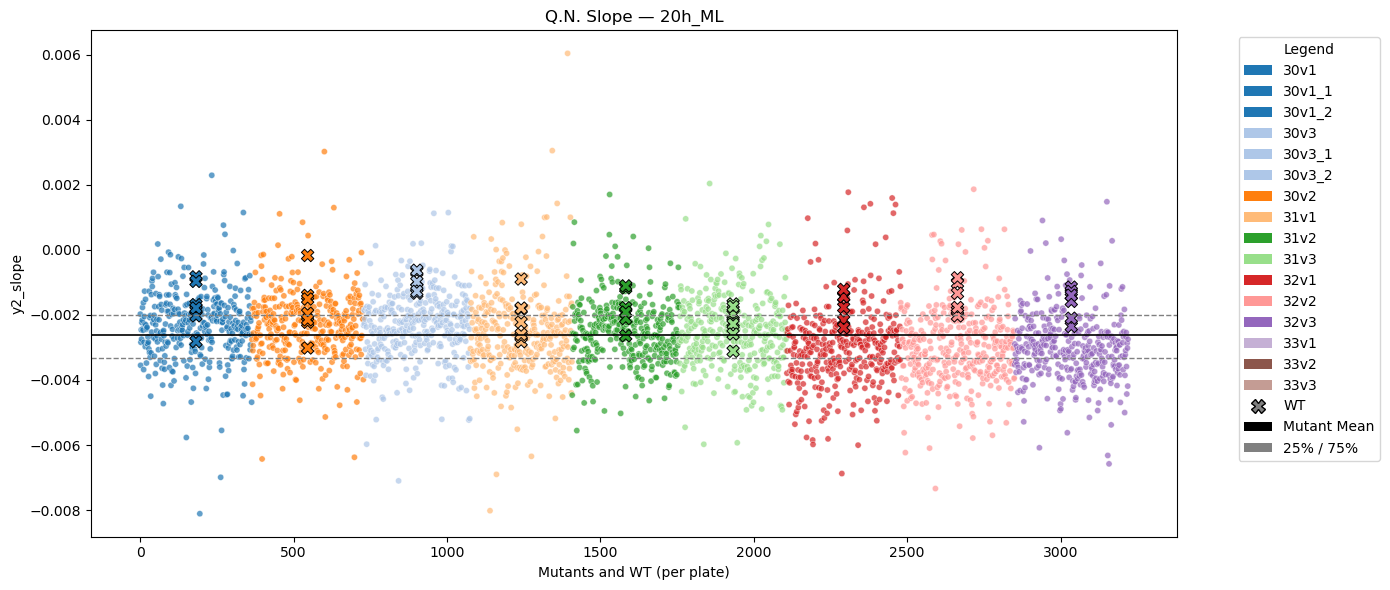

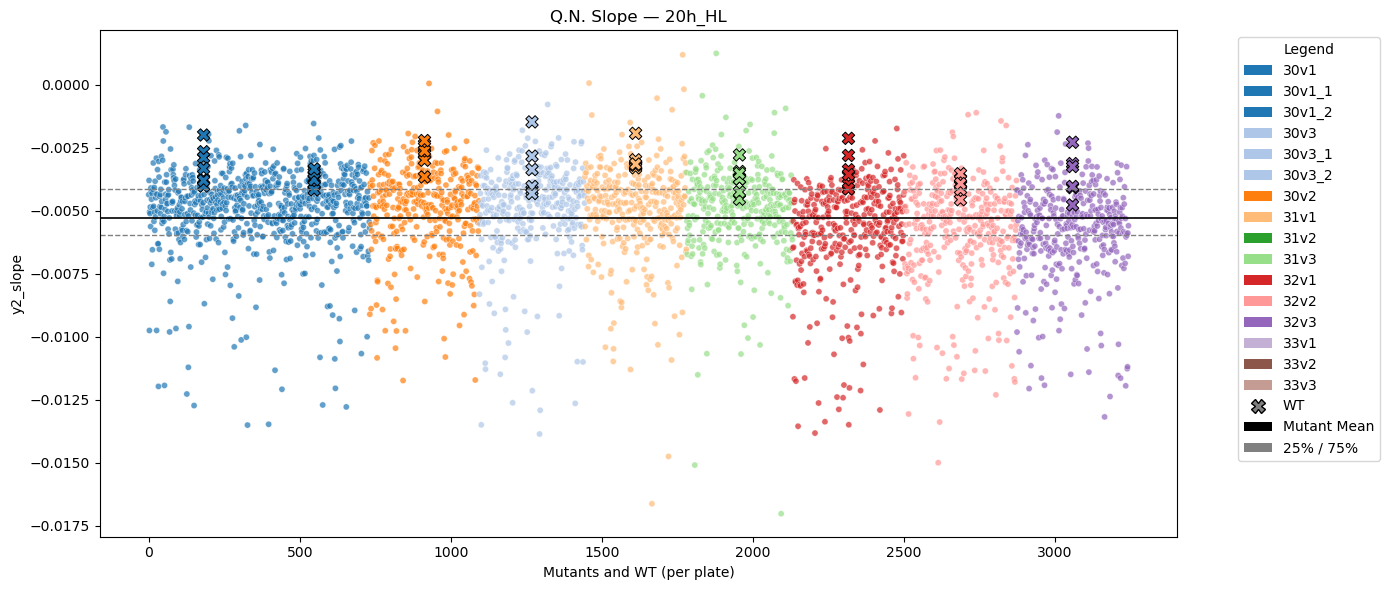

In [71]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
}

# Define remaining individual plates
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '33v1', '33v2', '33v3'
]

# Flatten all plates
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate colors
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]



light_regimes = ['20h_ML','20h_HL']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope'].mean()
    q1 = sub_df['y2_slope'].quantile(0.25)
    q3 = sub_df['y2_slope'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )

    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. Slope — {regime}")
    plt.tight_layout()
    plt.show()

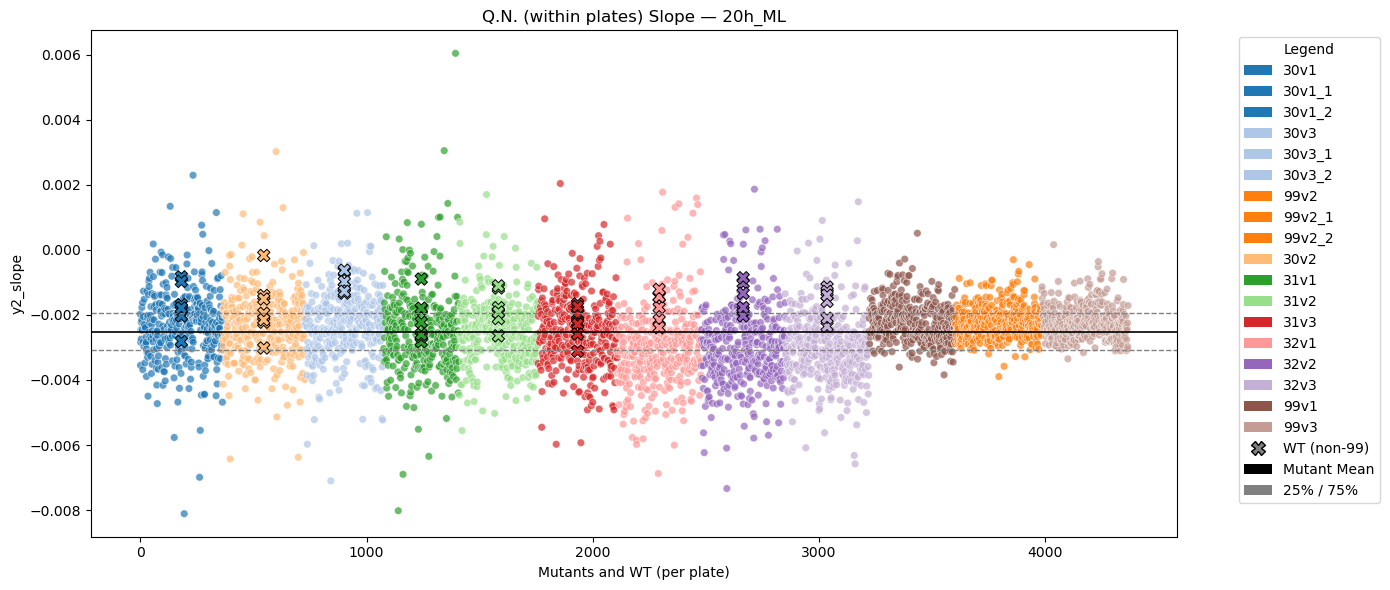

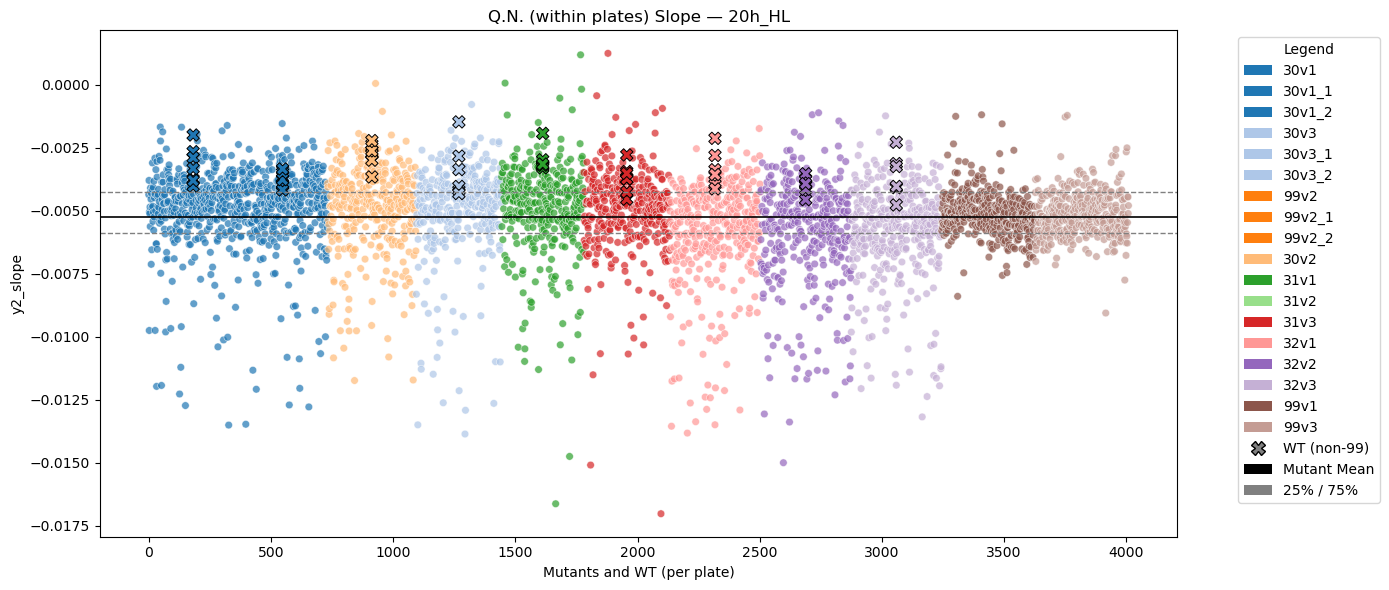

In [74]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['20h_ML', '20h_HL']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)

    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope'].mean()
    q1 = sub_df['y2_slope'].quantile(0.25)
    q3 = sub_df['y2_slope'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )
    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. (within plates) Slope — {regime}")
    plt.tight_layout()
    plt.show()

## compute 2 slopes

In [75]:
df_alter = phase2_qn_df1[phase2_qn_df1['light_regime'].isin(['2h-2h','10min-10min', '1min-1min', '30s-30s','5min-5min','1min-5min'])]
df_alter

plate measurement  start_date light_regime  dark_threshold  \
2681   30v1          M7  2024-06-14        2h-2h       14.942107   
2683   30v1          M7  2024-06-14        2h-2h       14.942107   
2684   30v1          M7  2024-06-14        2h-2h       14.942107   
2685   30v1          M7  2024-06-14        2h-2h       14.942107   
2686   30v1          M7  2024-06-14        2h-2h       14.942107   
...     ...         ...         ...          ...             ...   
35996  99v3          M7  2024-11-11    1min-5min       15.919251   
35997  99v3          M7  2024-11-11    1min-5min       15.919251   
35998  99v3          M7  2024-11-11    1min-5min       15.919251   
35999  99v3          M7  2024-11-11    1min-5min       15.919251   
36000  99v3          M7  2024-11-11    1min-5min       15.919251   

       light_threshold  num_frames   i   j     fv_fm  ...  elapsed_time_84  \
2681         20.769634         100   0   1  0.619602  ...              NaN   
2683         20.769634         100   0   3  0.551014  ...              NaN   
2684         20.769634         100   0   4  0.678250  ...              NaN   
2685         20.769634         100   0   5  0.697926  ...              NaN   
2686         20.769634         100   0   6  0.646199  ...              NaN   
...                ...         ...  ..  ..       ...  ...              ...   
35996        22.360340         180  15  18  0.636126  ...        19.034444   
35997        22.360340         180  15  19  0.588129  ...        19.034444   
35998        22.360340         180  15  20  0.634810  ...        19.034444   
35999        22.360340         180  15  21  0.642462  ...        19.034444   
36000        22.360340         180  15  22  0.651415  ...        19.034444   

       elapsed_time_85  elapsed_time_86  elapsed_time_87  elapsed_time_88  \
2681               NaN              NaN              NaN              NaN   
2683               NaN              NaN              NaN              NaN   
2684               NaN              NaN              NaN              NaN   
2685               NaN              NaN              NaN              NaN   
2686               NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
35996        19.451389           19.535        19.954444        20.038056   
35997        19.451389           19.535        19.954444        20.038056   
35998        19.451389           19.535        19.954444        20.038056   
35999        19.451389           19.535        19.954444        20.038056   
36000        19.451389           19.535        19.954444        20.038056   

       elapsed_time_89  elapsed_time_90  elapsed_time_91  y2_slope  \
2681               NaN              NaN              NaN  0.005771   
2683               NaN              NaN              NaN  0.004872   
2684               NaN              NaN              NaN  0.005183   
2685               NaN              NaN              NaN  0.003533   
2686               NaN              NaN              NaN  0.004798   
...                ...              ...              ...       ...   
35996        20.293889              NaN              NaN -0.001202   
35997        20.293889              NaN              NaN -0.000611   
35998        20.293889              NaN              NaN -0.000508   
35999        20.293889              NaN              NaN -0.000783   
36000        20.293889              NaN              NaN -0.000935   

       y2_intercept  
2681       0.327609  
2683       0.305710  
2684       0.417657  
2685       0.399466  
2686       0.369192  
...             ...  
35996      0.399915  
35997      0.361064  
35998      0.395787  
35999      0.395168  
36000      0.420470  

[26314 rows x 821 columns]

In [76]:
light_2h = pd.read_csv('Data light on off/20240917_99v1-M5_2h-2h.csv', sep=';')
light_2h = light_2h.loc[:, ~light_2h.columns.str.contains('^Unnamed')]
light_2h = light_2h.iloc[1:-1].reset_index(drop=True)

light_1min = pd.read_csv('Data light on off/20240913_99v1-M1_1min-1min.csv', sep=';')
light_1min = light_1min.loc[:, ~light_1min.columns.str.contains('^Unnamed')]
light_1min = light_1min.iloc[1:-1].reset_index(drop=True)

light_10min = pd.read_csv('Data light on off/20240919_99v1-M7_10min-10min.csv', sep=';')
light_10min = light_10min.loc[:, ~light_10min.columns.str.contains('^Unnamed')]
light_10min = light_10min.iloc[1:-1].reset_index(drop=True)

light_30s=pd.read_csv('Data light on off/20240918_99v1-M6_30s-30s.csv', sep=';')
light_30s = light_30s.loc[:, ~light_30s.columns.str.contains('^Unnamed')]
light_30s = light_30s.iloc[1:-1].reset_index(drop=True)

light_1min_5min = pd.read_csv('Data light on off/20240920_99v1-M8_1min-5min.csv', sep=';')
light_1min_5min = light_1min_5min.loc[:, ~light_1min_5min.columns.str.contains('^Unnamed')]
light_1min_5min = light_1min_5min.iloc[1:-1].reset_index(drop=True)

light_5min_5min = pd.read_csv('Data light on off/20241123_99v1-M8_5min-5min.csv', sep=';')
light_5min_5min = light_5min_5min.loc[:, ~light_5min_5min.columns.str.contains('^Unnamed')]
light_5min_5min = light_5min_5min.iloc[1:-1].reset_index(drop=True)

In [77]:
def feature_with_light_split(df, light_dict, n_timepoints_dict):
    """
    df: DataFrame in wide format (each row = one mutant)
    light_dict: dict mapping light_regime to corresponding light_XX DataFrame
    n_timepoints_dict: dict mapping light_regime to number of timepoints (40 or 80)
    """

    all_results = []

    for regime, group_df in df.groupby('light_regime'):
        
        if regime not in light_dict:
            continue  # skip if no light info provided for this regime

        light = light_dict[regime]
        n_timepoints = n_timepoints_dict[regime]

        # Extract ON/OFF mask
        par_values = light['PAR'].values[:n_timepoints]
        mask_on = par_values > 0
        mask_off = par_values == 0

        time_cols = [f'elapsed_time_{i}' for i in range(2, n_timepoints + 2)]
        y_cols = [f'y2_{i}' for i in range(1, n_timepoints + 1)]

        def compute_slopes(row):
            
            time_vals = row[time_cols].values.astype(float)
            y_vals = row[y_cols].values.astype(float)
        
            result = {
                'y2_slope_on': np.nan,
                'y2_intercept_on': np.nan,
                'y2_slope_off': np.nan,
                'y2_intercept_off': np.nan,
            }
        
            # ON
            # valid_on = mask_on & ~np.isnan(y_vals)
            valid_on = mask_on & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_on.sum() >= 2:
                model_on = LinearRegression()
                model_on.fit(time_vals[valid_on].reshape(-1, 1), y_vals[valid_on])
                result['y2_slope_on'] = model_on.coef_[0]
                result['y2_intercept_on'] = model_on.intercept_
        
            # OFF

            # valid_off = mask_off & ~np.isnan(y_vals)
            valid_off = mask_off & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_off.sum() >= 2:
                model_off = LinearRegression()
                model_off.fit(time_vals[valid_off].reshape(-1, 1), y_vals[valid_off])
                result['y2_slope_off'] = model_off.coef_[0]
                result['y2_intercept_off'] = model_off.intercept_
        
            return pd.Series(result)
        print(regime)

        slopes = group_df.apply(compute_slopes, axis=1)
        result = pd.concat([group_df, slopes], axis=1)
        #.reset_index(drop=True)
        all_results.append(result)

    # Combine results from all regimes
    return pd.concat(all_results, ignore_index=True)

In [78]:
light_dict = {
    '2h-2h': light_2h,
    '10min-10min': light_10min,
    '1min-1min': light_1min,
        '30s-30s': light_30s,

    '5min-5min':light_5min_5min,
    '1min-5min':light_1min_5min
}

n_timepoints_dict = {
    '2h-2h': 48,
    '10min-10min': 84,
    '1min-1min': 88,
    '30s-30s': 88,
    '5min-5min':88,
    '1min-5min':88
}

df1 = feature_with_light_split(df_alter, light_dict, n_timepoints_dict)

10min-10min
1min-1min
1min-5min
2h-2h
30s-30s
5min-5min


In [80]:
# Separate WT and mutants
wt_df =df1[df1['mutant_ID'] == 'WT']
mutant_df =df1[df1['mutant_ID'] != 'WT']

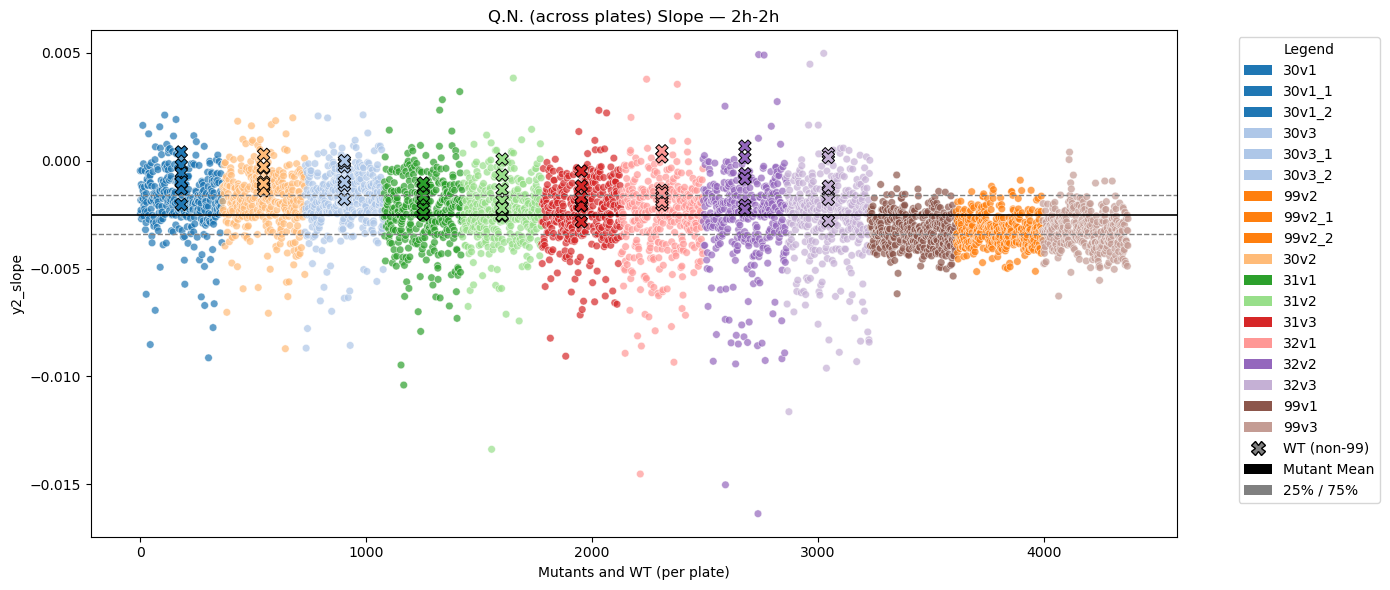

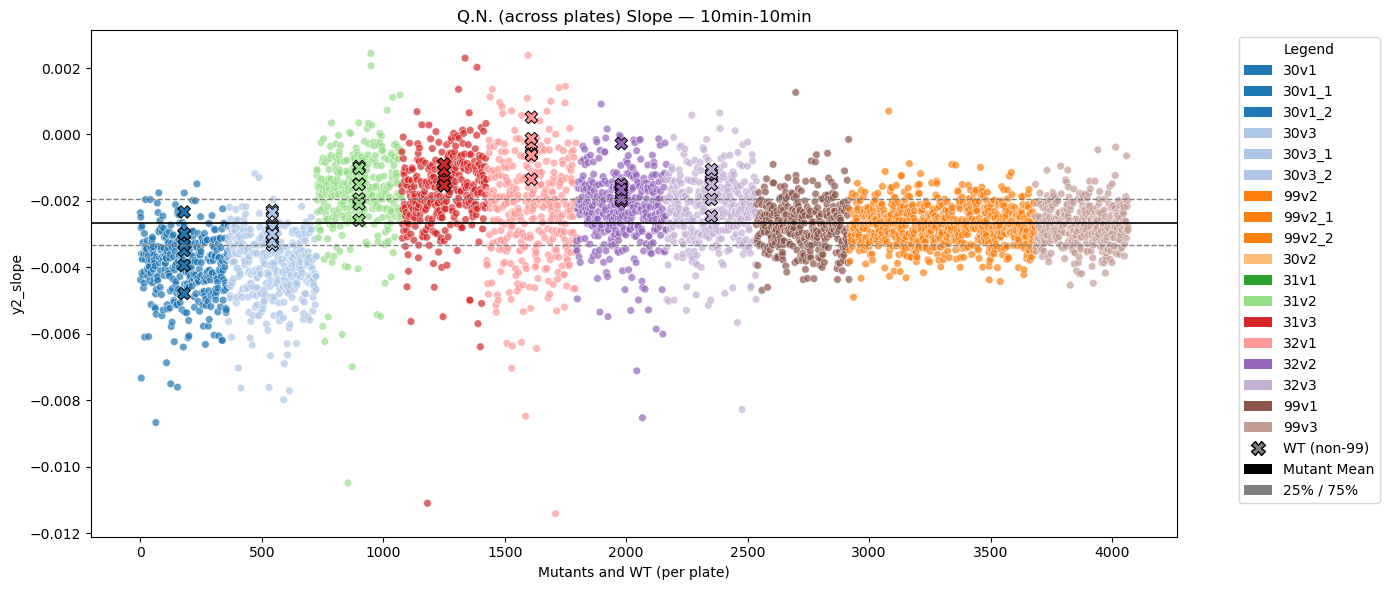

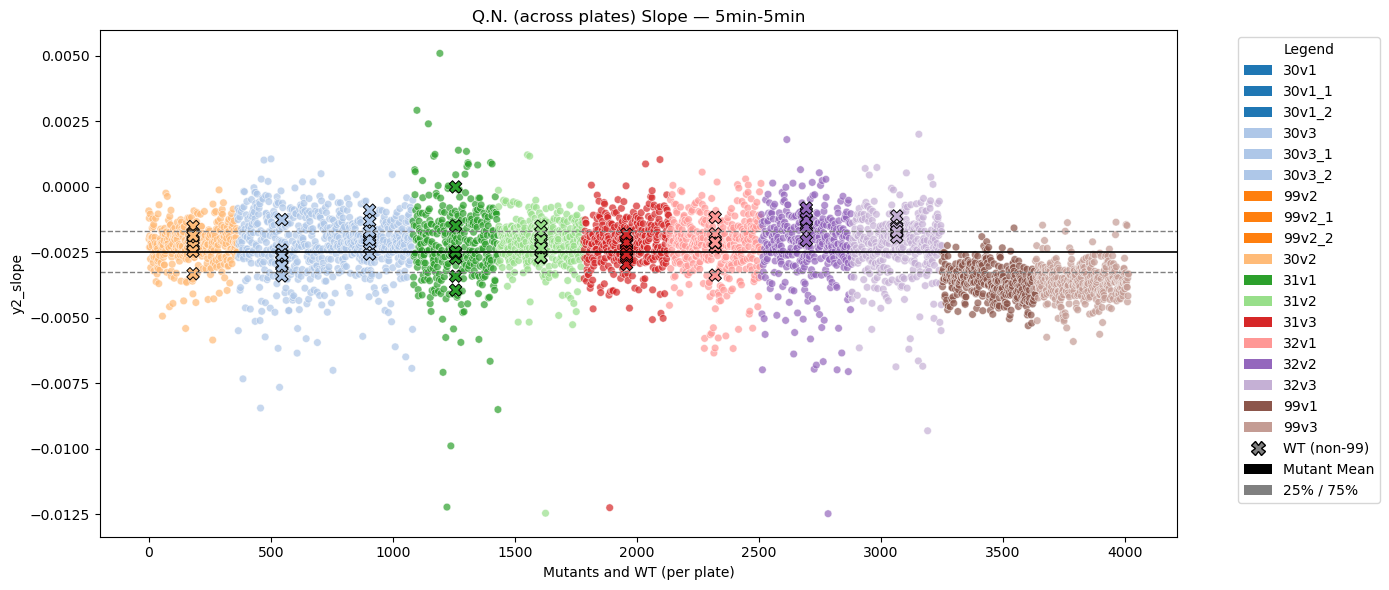

In [81]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['2h-2h','10min-10min', '5min-5min']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)

    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. (across plates) Slope — {regime}")
    plt.tight_layout()
    plt.show()

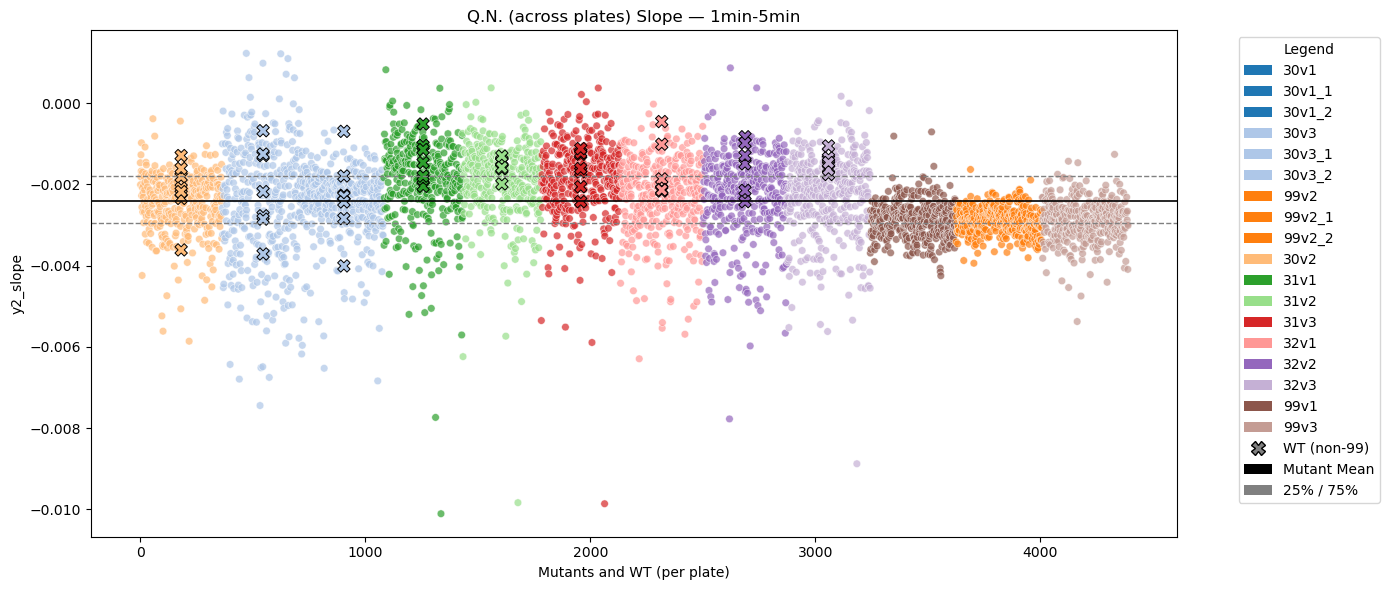

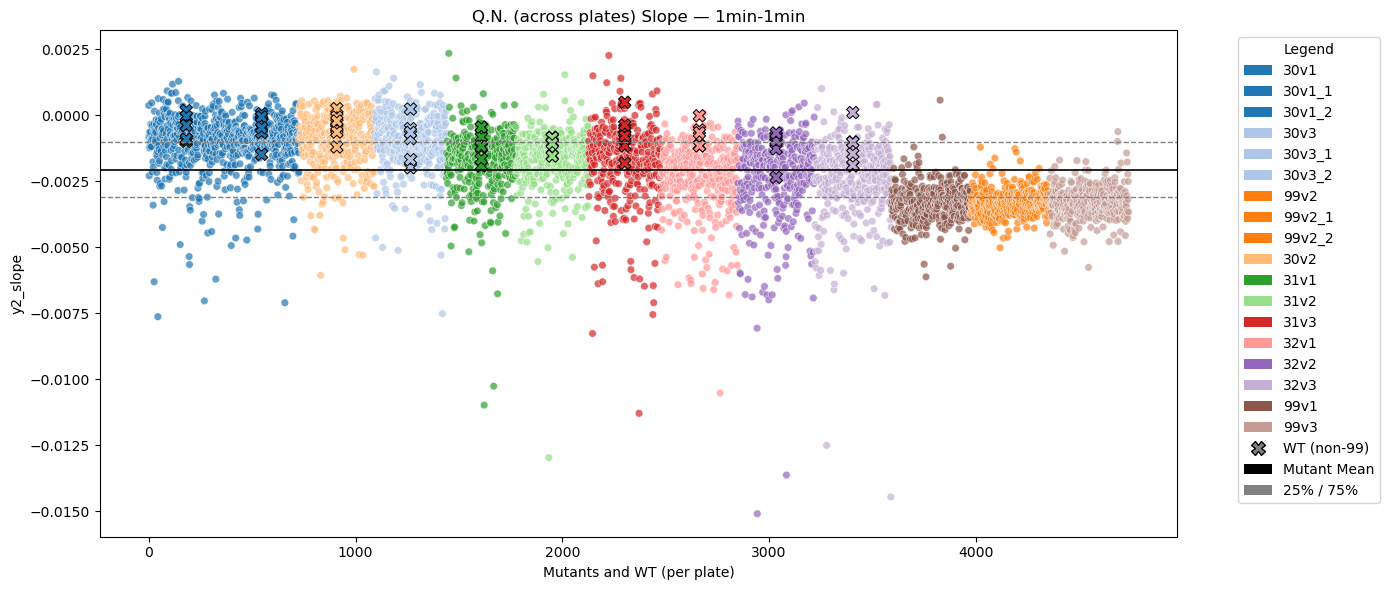

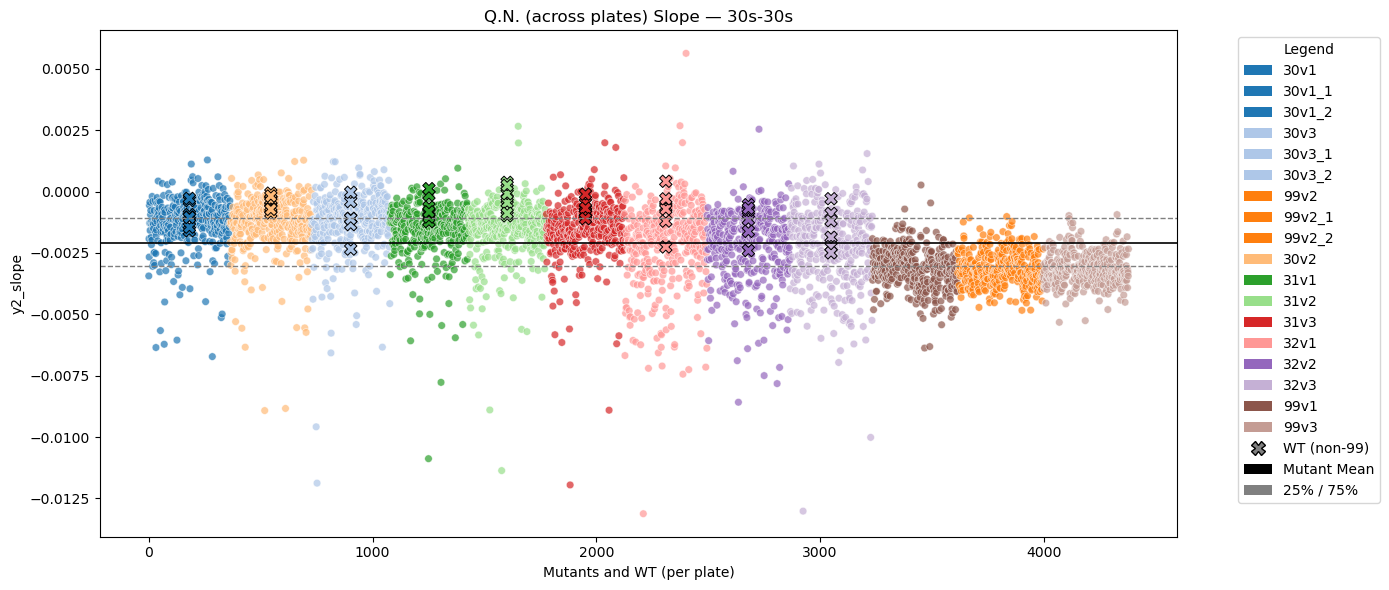

In [82]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
    '99v2_group': ['99v2', '99v2_1', '99v2_2']
}

# Define remaining individual plates (including 99v1, 99v3 as separate)
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '99v1', '99v3'
]

# Flatten all plates for plotting and color assignment
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate color palette
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors to each plate
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]

# Define light regimes to loop through
light_regimes = ['1min-5min','1min-1min', '30s-30s']

for regime in light_regimes:
    # Filter data for current light regime
    # After filtering mutant_df to get sub_df
    sub_df = mutant_df[(mutant_df['light_regime'] == regime)].copy()
    sub_df = sub_df[sub_df['plate'].isin(all_plates)]  # Only include target plates
    
    # ADD WT plates that start with '99' from wt_df and are in all_plates
    wt_99_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if p.startswith('99')]))
    ].copy()
    
    # Append to sub_df
    sub_df = pd.concat([sub_df, wt_99_df], ignore_index=True)

    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats for horizontal lines
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot all relevant data (including 99xx) as dots
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=30,
        legend=False
    )

    # Plot wild types from standard WT df (excluding 99 plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin([p for p in all_plates if not p.startswith('99')]))
    ].copy()

    # Align index for WT plotting
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot WT as X marker
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Add horizontal reference lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=plate)
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT (non-99)'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    # Final plot settings
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Q.N. (across plates) Slope — {regime}")
    plt.tight_layout()
    plt.show()

In [83]:
alt_light_regimes = ['2h-2h', '10min-10min', '1min-1min', '30s-30s', '5min-5min', '1min-5min']

# 2. Separate out the two subsets
df_alt= df1.copy()  # includes extra columns
df_non_alt = phase2_qn_df1[~phase2_qn_df1['light_regime'].isin(alt_light_regimes)].copy()

# 3. Make sure df_non_alt has the same columns (add missing columns as NaN)
for col in df_alt.columns:
    if col not in df_non_alt.columns:
        df_non_alt[col] = np.nan

# 4. Reorder columns to match df_alt
df_non_alt = df_non_alt[df_alt.columns]

# 5. Concatenate the full DataFrame
combined_df = pd.concat([df_alt, df_non_alt], ignore_index=True)
combined_df.shape

(34808, 825)

In [84]:
combined_df.to_csv('phase2_99_qn_within_slopes(5.18).csv',index=False)